## IMPORTING LIBRARIES AND DATASET DOWNLOAD

In [1]:
# System Libraries
import os
from pathlib import Path
import tarfile
from IPython.display import Audio, clear_output

# Handling Data Libraries
import pandas as pd
import numpy as np

# Plot Libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files.
'''
import librosa
import librosa.display
'''

# ML libraries
'''
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
'''

# DL libraries
'''
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
'''

# Handling warnings library
'''
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
''';

The dataset is distributed on this webpage https://sail.usc.edu/iemocap/ under request, after the request is accepted they provide you a download link that expire in 48 hours therefore we uploaded a lighter copy of it on kaggle as a private dataset (only the files we were interested in), therefore to run the following cell you just have to ask the access to Riccardo Paolini, we will provide you the access as soon as possible, then you have to download a ***kaggle.json*** file from kaggle to do that follow this steps:
- go to https://www.kaggle.com/
- sign up/in to your account on kaggle
- click on your propic in the top right corner
- click "Your Profile -> Account -> Create New API Token"

after this steps the download of your ***kaggle.json*** file should have started.
By running the following cell you are requested to upload the ***kaggle.json*** therefore the download of the private dataset should start.

## DATASET DESCRIPTION (Copy Paste of the README.txt file of the dataset)

Thank you for your interest in the USC_IEMOCAP database.  The USC_IEMOCAP database contains audio, transcriptions, video, and motion-capture(MoCap) recordings of dyadic mixed-gender pairs of actors.  There are five sessions in the database (ten actors total). For complete information about IEMOCAP please refer to:

Busso, Carlos et al.  "IEMOCAP: Interactive emotional dyadic motion capture database."  Journal of Language Resources and Evaluation.  Volume 42, Number 4.  pp. 335-359.  2008

as well as our website: http://sail.usc.edu/iemocap/

The recorded dialogs are either improvisations of affective scenarios, or performances of theatrical scripts. They have been manually segmented into utterances. Each utterance from either of the actors in the interaction has been evaluated categorically over the set of: {angry, happy, sad, neutral, frustrated, excited, fearful, surprised, disgusted, other} by at least three different annotators, and dimensionally over the axes of: valence (positive vs. negative); activation (calm vs. excited); and dominance (passive vs. aggressive) by at least two different annotators. 

In each recording of a session only one actor wears MoCap markers while both are being recorded by microphones and cameras. Thus there are available MoCap data (facial expression, head and hand movement) for one actor per recording, while there are wavefile and videos for both actors. The naming convention regarding the data is e.g., Ses01F_impro01 while indicates Session1, where the Female actor is wearing the markers and actors are performing improvisation 1. The release contains two formats: dialog format which contains data from the entire dyadic interaction and the sentence format where the data per dialog (recording) have been further segmented into utterances (see folders SessionX/dialog and SessionX/sentences respectively). For the utterance format the naming is as follows: Ses01F_impro01_M000 indicates first session, Female actor is wearing markers, actors are performing improvisation 1 and this is the first utterance of the Male actor. The timing of the sentences in each dialog can be found in the lab files in SessionX/dialog/lab

The MoCap data can be found in either dialog format or sentece format in the corresposding folders. The MOCAP_rotated folder contains motion-capture data rotated and translated such that the central nose marker always represents the (0,0,0) xyz-tuple. The MoCap data are in .txt files where each line is a frame number and each column is a marker coordinate. Please consult the headers of the MoCap files and the diagram of the facial markers (Documentation/FIVE_face_markers2.png) to see the correspondence between marker positions and marker names. The hand mocap data is in MOCAP_hand folder, while the information of head translation (x,y,z) and head rotation (yaw, pitch, roll) is in MOCAP_head folder. 

We are also distributing wavefiles (sentence and dialog format), the videos of the recordings (SessionX/dialog/avi/), and transcriptions of the dialogs (SessionX/dialog/transcriptions/). For the segmented utterances we are also providing the results of forced alignment which contain detail phoneme, syllable and word level timing information (SessionX/sentences/ForcedAlignment/).

The evaluations (emotional annotations) for each recording and each uterance are contained in folder SessionX/dialog/Evaluation/. Each file provides the detailed evaluation reports for the categorical evaluators (e.g., C-E1), the dimensional evaluators (e.g., A-E1), and the self-evaluatiors (e.g., C-F1 or C-M1, A-F1 or A-M1). The utterance-level information can be found in the first line of an utterance summary.  The first entry represents the start and end times for the utterance.  The second entry is the utterance name (e.g., Ses01_impro01_F003).  The third entry is the ground truth (if no majority ground truth could be assigned, the ground truth is labeled xxx).  The final engry is the average dimensional evaluation (over the evaluators, except the self-evaluators).

We are providing  a full release of this data in the hopes that it will provide a valuable resource to the emotion recognition community. We request that any published work using IEMOCAP should cite the paper entitled: "IEMOCAP: Interactive emotional dyadic motion capture database" (JLRE, 2008). If you do any further evaluation of the data, we request that you send us the detailed results so that we may provide a more detailed resource to the community. Also, please feel free to send us feedback regarding the database: how it is being used, if the information provided is sufficient, and how you have decided to utilize the evaluation information. Thanks again.


## BUILDING OF A DATAFRAME

In [2]:
#folder = os.path.join(os.getcwd(), 'IEMOCAP')
folder = '../input/iemocap'

conv_id = 0

df = []
for session in os.listdir(folder):
    session_path = os.path.join(folder, session)
    # 'dialogue' folder contains Emotions and Transcripts
    # 'sentences' folder contains Audios

    trans_folder = os.path.join(session_path, 'dialog', 'transcriptions')

    for trans_name in os.listdir(trans_folder):
        if trans_name[:2] != '._':
            emo_path = os.path.join(session_path, 'dialog', 'EmoEvaluation', trans_name)
            with open(os.path.join(trans_folder, trans_name), encoding='utf8') as trans_file, open(emo_path, encoding='utf8') as emo_file:
                conv_id += 1
                turn_id = 0
                for line in trans_file:
                    audio_name, text = line.split(':')
                    if trans_name.split('.')[0] in audio_name:
                        turn_id += 1

                        wav_path = os.path.join(session_path, 'sentences', 'wav', trans_name.split('.')[0], audio_name.split(' ')[0] + '.wav')

                        reached = False
                        count_em = {'Anger': 0, 'Happiness': 0, 'Sadness': 0, 'Neutral': 0, 'Frustration': 0, 'Excited': 0, 'Fear': 0, 'Surprise': 0, 'Disgust': 0, 'Other': 0}
                        for emo_line in emo_file:
                            if audio_name.split(' ')[0] in emo_line:
                                emotion, vad = emo_line.split('\t')[-2:]
                                vad = vad[1:-2].split(',')
                                reached = True
                            elif emo_line[0] == 'C' and reached:
                                evaluator = emo_line.split(':')[0]
                                emotions = emo_line.split(':')[1].split('(')[0].split(';')
                                emotions = [em.strip() for em in emotions]
                                for em in emotions:
                                    if em != '':
                                        count_em[em] += 1
                            elif reached:
                                emo_file.seek(0)
                                break
                                    

                        row = {'conv_id': conv_id, 
                                'turn_id': turn_id, 
                                'sentence': text.strip(),
                                'path': wav_path,
                                'emotion': emotion,
                                'valence': float(vad[0]),
                                'activation': float(vad[1]),
                                'dominance': float(vad[2])
                                }
                        
                        df.append(dict(**row, **count_em))

df = pd.DataFrame(df)


### DATAFRAME INSPECTION

In [3]:
df.shape

(10087, 18)

In [4]:
df.sample(20)

,conv_id,turn_id,sentence,path,emotion,valence,activation,dominance,Anger,Happiness,Sadness,Neutral,Frustration,Excited,Fear,Surprise,Disgust,Other
8961,131,3,Ok. I've- I've just been talking to this mach...,../input/iemocap/Session2/sentences/wav/Ses02F...,fru,2.0000,3.5000,4.5000,0,0,0,0,3,0,0,0,0,0
3176,46,1,Guess what?,../input/iemocap/Session5/sentences/wav/Ses05M...,exc,4.5000,2.0000,2.0000,0,0,0,0,0,3,0,0,0,0
7873,115,52,A whole year? --We're not talking about like a...,../input/iemocap/Session3/sentences/wav/Ses03M...,sad,2.0000,4.0000,4.0000,1,0,3,0,2,0,0,0,0,0
418,7,22,Do you want my jacket?,../input/iemocap/Session4/sentences/wav/Ses04F...,xxx,3.0000,2.5000,2.0000,0,0,0,1,1,1,0,0,0,0
8295,122,20,Twice is every time we've tried. That's ever.,../input/iemocap/Session2/sentences/wav/Ses02F...,fru,2.0000,3.5000,4.0000,0,0,0,0,3,0,0,0,0,0
7389,109,45,Some people.,../input/iemocap/Session3/sentences/wav/Ses03F...,sad,2.0000,3.0000,3.0000,0,0,0,0,0,0,0,0,0,0
8912,130,48,No.,../input/iemocap/Session2/sentences/wav/Ses02M...,xxx,2.5000,2.0000,2.5000,0,0,1,1,1,0,0,0,0,0
7108,105,54,I'm just so excited to start my life.,../input/iemocap/Session3/sentences/wav/Ses03F...,xxx,3.5000,3.5000,2.5000,0,0,0,0,0,0,0,0,0,0
4325,62,27,I almost got married two years ago.,../input/iemocap/Session1/sentences/wav/Ses01M...,neu,3.5000,2.0000,2.0000,0,0,0,2,0,1,0,0,0,0
1307,20,87,"Very well, if you insist on being boorish and ...",../input/iemocap/Session4/sentences/wav/Ses04M...,ang,2.5000,3.5000,3.5000,3,0,0,0,0,0,0,0,0,0


### AUDIO INSPECTION

In [5]:
Audio(df.iloc[0, 3]) # ispection of the first audio (to change audio just change the first index)

### GOLDEN LABELS INSPECTION

In [6]:
for em in np.unique(df.emotion):    
    print(f"emotion {em}: {np.sum(df.emotion == em)}")

emotion ang: 1111
emotion dis: 1
emotion exc: 1108
emotion fea: 35
emotion fru: 2053
emotion hap: 541
emotion neu: 1634
emotion oth: 3
emotion sad: 1089
emotion sur: 99
emotion xxx: 2413


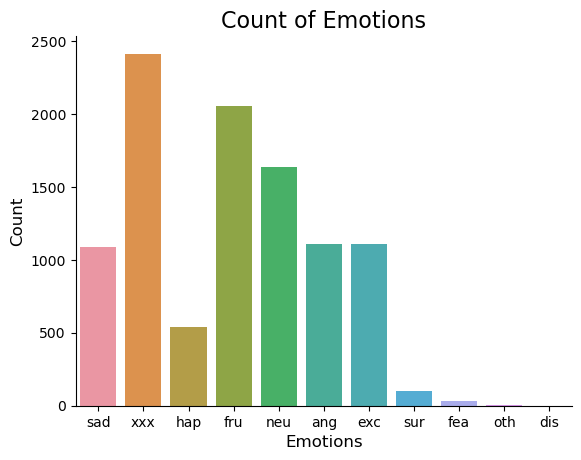

In [7]:
plt.title('Count of Emotions', size=16)
sns.countplot(x=df.emotion)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

Let's do some consideration of the above plotted distribution of this golden labels:

- We can see how the emotion "xxx" is very common emotion (almost 2500 occurrences) but not very meaningful, our explanation behind the behavior of this golden label is that there isn't a predominant emotion in the classifications of the evaluators (excluding the self-evaluator) therefore an "xxx" gold label shows up.

- We can see that a lot of our labels are undersampled in comparison to the other labels, data augmentation could help in this cases

The strategies that we thinked of for handling the "xxx" labels are by considering them as missing values and trying to fill them by reconstruct a predominant emotion also considering the self-evaluators with more weights with respect to the other evaluators, but that would by definition modify the golden label we are provided with.

## VAD Inspection (Valence, Activation, Dominance)

interactive = True # CHANGE THIS TO False IN ORDER TO SEE AN INTERACTIVE PLOT
title = "VAD Inspection with reference to golden labels"

if interactive:
    fig = px.scatter_3d(df, x='valence', y='activation', z='dominance',
                        color='emotion',
                        title=title)
    fig.show()
else:
    sns.set(style = "darkgrid")

    fig = plt.figure(figsize=(15,10), dpi= 100, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111, projection = '3d')

    for e in df.emotion.unique():
        ax.scatter(df.valence[df.emotion == e], df.activation[df.emotion == e], df.dominance[df.emotion == e], label = e)

    ax.set_xlabel("valence")
    ax.set_ylabel("activation")
    ax.set_zlabel("dominance")

    ax.legend()

    plt.title(title)
    plt.show()

The only inspection for the VAD values that came in our mind is a visual inspection with reference to the golden labels and it seems that the golden labels are reflected in the VAD space with some clusters, that doesn't seem to be the case for the 'xxx' label that seems to be distributed quite randomly in this space.

# Text Classification


# Background - Emotion evaluators

The final **emotion** conveyed by the text is determined by how frequently the following **emotion-evaluators**: 

1. Anger 
2. Happiness 
3. Sadness 
4. Neutral 
5. Frustration 
6. Excited 
7. Fear 
8. Surprise 
9. Disgust 
10. Other

are conveyed by the text. This leads to situation where the there exists no single dominant evaluator, which can be used to determine the final emotion. Such texts were labelled under the class **xxx**. 

# Formulation
A direct approach would be to treat the emotion **xxx** as an additional class, and solve it as a NLP **sequence-classification** task. 

Some of the problems associated with solving a  **sequence-classification** task:
- emotions suffers from sever **class imbalance**. 
- 'xxx' class has been introduced as an additional class, but there is a lot of ambiguity in the classification as 'xxx' class. Consequently, the data is heavely weighted towards this emotion as indicated by the distribution of the emotions.  

In order to overcome this problem of class imbalance,instead of solving a `sequence classification` task,  we solve a `multi-label regression` problem with some post processing. The aim of the regression task would be to predict the score of the 10 `emotion-evaluators` of final emotion. This would also benefit from that fact that the ambigious class `xxx` is not predicted, instead use the predicted score of 10 `emotion-evaluators` to determine **final emotions** based on post-processing. 


### EDA

In [8]:
emotion_evaluators = df.columns[8:].tolist()
emotion_evaluators

['Anger',
 'Happiness',
 'Sadness',
 'Neutral',
 'Frustration',
 'Excited',
 'Fear',
 'Surprise',
 'Disgust',
 'Other']

### Distribution of `emotion_evaluators`

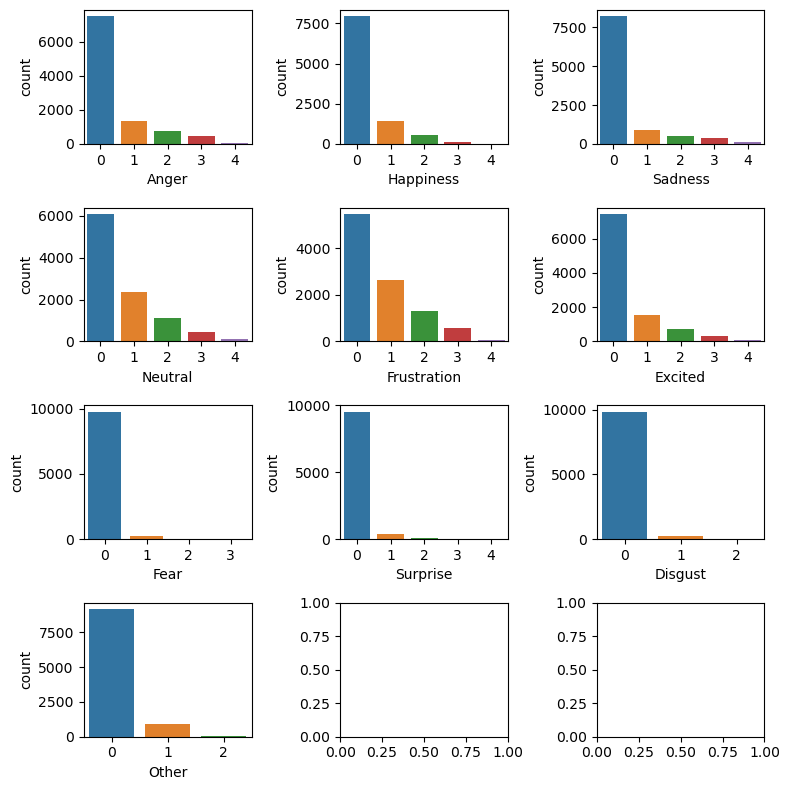

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 3, figsize=(8,8)); ax = np.ravel(axes)
for i, em in enumerate(emotion_evaluators):
    sns.countplot(data=df[emotion_evaluators], x=em, ax=ax[i])
plt.tight_layout()
plt.show()


### Create label: 
Concatenate the 10 evaluators of emotion: `['Anger', 'Happiness', ..., 'Other']` to create a single target label

In [10]:
label =[]
for idx, row in df.iterrows():
    emotions = [
        row['Anger'], row['Happiness'], row['Sadness'], row['Neutral'], row['Frustration'], 
        row['Excited'], row['Fear'], row['Surprise'], row['Disgust'], row['Other']
    ]
    label.append(emotions)

df['label'] = label

df.head(5)


,conv_id,turn_id,sentence,path,emotion,valence,activation,dominance,Anger,Happiness,Sadness,Neutral,Frustration,Excited,Fear,Surprise,Disgust,Other,label
0,1,1,"Hey, how you doing?",../input/iemocap/Session4/sentences/wav/Ses04M...,sad,3.0,2.0,1.5,0,0,3,0,0,0,0,0,0,0,"[0, 0, 3, 0, 0, 0, 0, 0, 0, 0]"
1,1,2,I'm sorry.,../input/iemocap/Session4/sentences/wav/Ses04M...,sad,2.5,2.0,1.5,0,0,3,0,0,0,0,0,0,0,"[0, 0, 3, 0, 0, 0, 0, 0, 0, 0]"
2,1,3,Thanks.,../input/iemocap/Session4/sentences/wav/Ses04M...,sad,2.5,2.0,2.0,0,0,2,1,0,0,0,0,0,0,"[0, 0, 2, 1, 0, 0, 0, 0, 0, 0]"
3,1,4,I know- I know there's nothing I can say that ...,../input/iemocap/Session4/sentences/wav/Ses04M...,sad,2.0,2.0,2.0,0,0,3,0,0,0,0,0,0,0,"[0, 0, 3, 0, 0, 0, 0, 0, 0, 0]"
4,1,5,I know. I just -- I don't know. It's just we...,../input/iemocap/Session4/sentences/wav/Ses04M...,sad,2.0,2.5,3.0,0,0,3,0,0,0,0,0,0,0,"[0, 0, 3, 0, 0, 0, 0, 0, 0, 0]"


### Split the data in to train and test using `emotion` as the label.


In [11]:
# Split the data in to train and test

from sklearn.model_selection import train_test_split

text = df.sentence; emotion = df.emotion

X_train, X_test, y_train, y_text = train_test_split(text, emotion, test_size=0.1, shuffle=True, random_state=42)

print('Size of TRAIN dataset = ', X_train.shape)
print('Size of TEST dataset = ', X_test.shape)


Size of TRAIN dataset =  (9078,)
Size of TEST dataset =  (1009,)


### Create train and test dataframe

In [12]:
train_df = df.loc[X_train.index, ['sentence', 'label']].reset_index(drop=True)

test_df_0 = df.loc[X_test.index, ['sentence', 'label', 'emotion']].reset_index(drop=True)
test_df = test_df_0.copy()
test_df = test_df.drop(['emotion'], axis=1)

display(train_df.head())

display(test_df.head())

,sentence,label
0,Very amusing.,"[2, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
1,Thanks.,"[1, 0, 1, 1, 0, 0, 0, 0, 0, 1]"
2,"No, I don't have a passport.","[1, 0, 0, 2, 2, 0, 0, 0, 0, 0]"
3,MMhmm.,"[0, 0, 1, 3, 0, 0, 0, 0, 0, 0]"
4,What are you getting so excited about? I mean...,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 1]"


,sentence,label
0,I'll find out. But then after it's all over we...,"[0, 0, 0, 3, 0, 0, 0, 0, 0, 0]"
1,I can't be that strong. A whole year.,"[0, 0, 3, 0, 1, 0, 0, 0, 0, 0]"
2,"But you're so good with her. You know, she kno...","[0, 0, 2, 0, 2, 0, 0, 0, 0, 0]"
3,Everybody's going to come up. We're going to s...,"[0, 2, 0, 0, 0, 1, 0, 0, 0, 0]"
4,Where I'm going is not the safest place on the...,"[0, 0, 0, 0, 3, 0, 0, 0, 0, 0]"


### Load the dataframes as `datasets`

In [13]:
from datasets import Dataset

dataset_train = Dataset.from_pandas(train_df)
dataset_test = Dataset.from_pandas(test_df)

dataset_train

Dataset({
    features: ['sentence', 'label'],
    num_rows: 9078
})

### Parameters
1. Define the tokenizer 
2. Tokenize the sentence
3. load dataset at tf-dataset

In [14]:

#model_checkpoint = "roberta-base"
#model_checkpoint = "bert-base-uncased"

model_checkpoint = "distilbert-base-uncased"

BATCH_SIZE = 16 #


from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


def tokenization(text):
    return tokenizer(text["sentence"], truncation=True) # truncate sequences to be no longer than max token length for distilbert.

dataset_train = dataset_train.map(tokenization, batched=True)
dataset_test = dataset_test.map(tokenization, batched=True)


# Convert datasets to tf-datasets

from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_dataset_train = dataset_train.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols= 'label',
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
    shuffle=True
)

tf_dataset_test = dataset_test.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols= 'label',
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
    shuffle=False
)

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


### Check the contents of the tf dataset

In [15]:
for encode, label in tf_dataset_train.take(1):
    print(encode.keys())
    print()
    print(encode['input_ids'])
    print()
    print(encode['attention_mask'])
    print()
    print(label)
   

dict_keys(['input_ids', 'attention_mask'])

tf.Tensor(
[[  101  2093  2086  2038  2042  1037  2146  2051  1012   102     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [  101  2008  1005  1055  2025  1011  2053  1012   102     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [  101  1031  7239  1033  1012  2053  1010  2017  1005  1040  2131  2109
   2000  2009  1012   102     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
   

### Define the model

In [16]:
import tensorflow as tf
from transformers import TFAutoModel

def build_model(n_class_labels=10): 
    model = TFAutoModel.from_pretrained(model_checkpoint)

    x1 = tf.keras.layers.Input(shape=(None,), dtype=tf.int64)
    x2 = tf.keras.layers.Input(shape=(None,), dtype=tf.int64)    
    
    last_hidden_state = model(input_ids=x1, attention_mask=x2).last_hidden_state

    # Pooling layer
    x = tf.keras.layers.GlobalAveragePooling1D()(last_hidden_state)
    
    # Dense Layer
    x = tf.keras.layers.Dense(128, activation="relu")(x)

    # Dropout Regularization 
    x = tf.keras.layers.Dropout(0.2)(x)
    
    # Dense Layer
    outputs = tf.keras.layers.Dense(n_class_labels, activation="relu")(x)
    
    model = tf.keras.models.Model(
        inputs={'input_ids': x1, 'attention_mask': x2}, 
        outputs=outputs
    )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-6)
    
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer)
    
    return model
 
# Get the model ...

model = build_model()

# Train the model...

h = model.fit(
    tf_dataset_train,
    validation_data=tf_dataset_test,
    epochs=10
)

# Make Predictions ...

predictions = model.predict(tf_dataset_test)


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/10
567/567 [==============================] - 89s 119ms/step - loss: 0.4759 - val_loss: 0.4399
Epoch 2/10
567/567 [==============================] - 42s 74ms/step - loss: 0.4327 - val_loss: 0.3972
Epoch 3/10
567/567 [==============================] - 43s 75ms/step - loss: 0.4008 - val_loss: 0.3726
Epoch 4/10
567/567 [==============================] - 41s 72ms/step - loss: 0.3786 - val_loss: 0.3575
Epoch 5/10
567/567 [==============================] - 40s 71ms/step - loss: 0.3591 - val_loss: 0.3476
Epoch 6/10
567/567 [==============================] - 41s 72ms/step - loss: 0.3457 - val_loss: 0.3414
Epoch 7/10
567/567 [==============================] - 40s 71ms/step - loss: 0.3343 - val_loss: 0.3367
Epoch 8/10
567/567 [==============================] - 41s 72ms/step - loss: 0.3199 - val_loss: 0.3334
Epoch 9/10
567/567 [==============================] - 41s 72ms/step - loss: 0.3115 - val_loss: 0.3344
Epoch 10/10
64/64 [==============================] - 3s 28ms/step


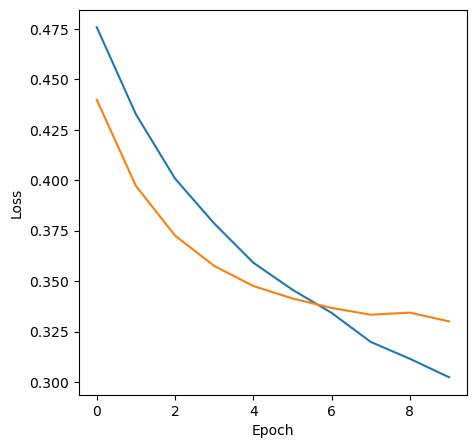

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


### Post Processing: Extract the `final emotions` from the predicted `emotion_evaluators`

In [18]:
index2label = {i: x.lower()[:3] for i, x in enumerate(df.columns[8:-1].tolist())}

def get_final_emotion(pred, index2label):
    indices = np.where(pred == pred.max())[0]    
    return 'xxx' if len(indices) > 1 else index2label[indices[0]]

predicted_emotions = [get_final_emotion(p, index2label) for p in predictions]

# Compute accuracy of the predictions ...

pred = np.array(predicted_emotions)
true = test_df_0['emotion'].values

accuracy = np.mean(true == pred)
print()
print('*'*50)
print('Prediction Accuray = ', accuracy)
print('*'*50)

# Save the predicted emotions ...
test_df_0['predicted emotion'] = pred.tolist()
test_df_0.to_csv('testdata_with_predictions.csv', index=False)

display(test_df_0.drop(['label'],axis=1).head(20))



**************************************************
Prediction Accuray =  0.40336967294350845
**************************************************


,sentence,emotion,predicted emotion
0,I'll find out. But then after it's all over we...,neu,fru
1,I can't be that strong. A whole year.,sad,sad
2,"But you're so good with her. You know, she kno...",fru,fru
3,Everybody's going to come up. We're going to s...,hap,exc
4,Where I'm going is not the safest place on the...,fru,fru
5,It's just...,xxx,sad
6,I heard him right through the floor of my room.,xxx,neu
7,"Um- You know, window is nice. I guess",neu,neu
8,"Obviously, we're not trying to lose your lugga...",neu,fru
9,[GARBAGE],fru,fru
